In [106]:
import numpy as np
from sklearn.datasets import fetch_20newsgroups
categories = [ 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware',
                'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey']
train_data = fetch_20newsgroups(subset='all', categories=categories, shuffle=True, random_state=42)
X = np.asarray(train_data.data)
y = [0 if x<4 else 1 for x in train_data.target]
y = np.asarray(y)

# 1) Transform Documents into TFIDF Vectors

In [107]:
import nltk
import string
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from nltk.stem import PorterStemmer

# stemming words from the same root
stemmer = PorterStemmer()
def tokenize_and_stem(text):
    tokens = nltk.tokenize.word_tokenize(text)
    tokens = [token.strip(string.punctuation)
                for token in tokens if token.isalnum()]
    tokens = [stemmer.stem(token) for token in tokens]
    return tokens

# vectorize documents
vectorizer = CountVectorizer(min_df=1, stop_words='english', tokenizer=tokenize_and_stem)
X_vect = vectorizer.fit_transform(X)
print(X_vect.shape)

# transform into TFIDF
tfidf_transformer = TfidfTransformer(sublinear_tf=True, use_idf=True)
X_tfidf = tfidf_transformer.fit_transform(X_vect)
print(X_tfidf.shape)

(7882, 57042)
(7882, 57042)


# 2) K-means Clustering with k=2

In [116]:
from sklearn import metrics
from sklearn.cluster import KMeans

# K-means clustering
km = KMeans(n_clusters=2)
for i in range(5):
    # try different permutation of rows
    perm = np.random.permutation(X_tfidf.shape[0])
    X_tfidf_ = X_tfidf[perm,:]
    y_ = y[perm]
    km.fit(X_tfidf_)
    predict = km.labels_

    # confusion matrix
    print(metrics.confusion_matrix(y_, predict))
    # clustering performance evaluations
    print("Homogeneity: %f" % metrics.homogeneity_score(y_, predict))
    print("Completeness: %f" % metrics.completeness_score(y_, predict))
    print("Adjusted Rand-Index: %f" % metrics.adjusted_rand_score(y_, predict))
    print("Adjusted Mutual Information: %f" % metrics.adjusted_mutual_info_score(y_, predict))

[[3903    0]
 [2250 1729]]
Homogeneity: 0.260456
Completeness: 0.343134
Adjusted Rand-Index: 0.184014
Adjusted Mutual Information: 0.260388
[[3903    0]
 [2265 1714]]
Homogeneity: 0.257699
Completeness: 0.341076
Adjusted Rand-Index: 0.180762
Adjusted Mutual Information: 0.257631
[[ 111 3792]
 [3781  198]]
Homogeneity: 0.763519
Completeness: 0.763553
Adjusted Rand-Index: 0.849315
Adjusted Mutual Information: 0.763498
[[   0 3903]
 [1729 2250]]
Homogeneity: 0.260456
Completeness: 0.343134
Adjusted Rand-Index: 0.184014
Adjusted Mutual Information: 0.260388
[[3903    0]
 [2252 1727]]
Homogeneity: 0.260088
Completeness: 0.342859
Adjusted Rand-Index: 0.183579
Adjusted Mutual Information: 0.260020


# 3) Dimensionality Reduction

- Truncated SVD (LSI)

95 dimensions give the max homogeneity score


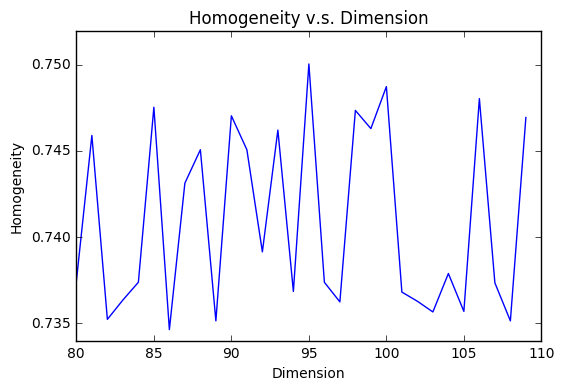

[[3759  144]
 [ 191 3788]]
Homogeneity: 0.746947
Completeness: 0.746900
Adjusted Rand-Index: 0.837197
Adjusted Mutual Information: 0.746876


In [120]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

dimension = range(80,110)
max_score = -1
scores = []
for n_components in dimension:
    lsa = TruncatedSVD(n_components=n_components, n_iter=10, random_state=42)
    ppl = make_pipeline(lsa, Normalizer(copy=False))
    X_lsa = ppl.fit_transform(X_tfidf)

    km.fit(X_lsa)
    predict = km.labels_
    score = metrics.homogeneity_score(y, predict)
    scores.append(score)
    if score>max_score:
        max_score = score
        max_n_components = n_components
        lsa_model = km

print("%d dimensions give the max homogeneity score" % max_n_components)
plt.plot(dimension, scores)
plt.title("Homogeneity v.s. Dimension")
plt.xlabel("Dimension")
plt.ylabel("Homogeneity")
plt.show()

# clustering performance evaluations
predict = lsa_model.labels_
print(metrics.confusion_matrix(y, predict))
print("Homogeneity: %f" % metrics.homogeneity_score(y, predict))
print("Completeness: %f" % metrics.completeness_score(y, predict))
print("Adjusted Rand-Index: %f" % metrics.adjusted_rand_score(y, predict))
print("Adjusted Mutual Information: %f" % metrics.adjusted_mutual_info_score(y, predict))

- Applying Logarithm to Reduced Data from LSI

In [124]:
from sklearn.preprocessing import MinMaxScaler

lsa = TruncatedSVD(n_components=max_n_components, n_iter=10, random_state=42)
ppl = make_pipeline(lsa, Normalizer(copy=False))
X_lsa = ppl.fit_transform(X_tfidf)

min_max_scaler = MinMaxScaler()
X_lsa_minmax = min_max_scaler.fit_transform(X_lsa)
X_lsa_minmax[X_lsa_minmax<1e-10] = 1e-10
X_lsa_log = np.log(X_lsa_minmax)

km.fit(X_lsa_log)
predict = km.labels_

# clustering performance evaluations
print(metrics.confusion_matrix(y, predict))
print("Homogeneity: %f" % metrics.homogeneity_score(y, predict))
print("Completeness: %f" % metrics.completeness_score(y, predict))
print("Adjusted Rand-Index: %f" % metrics.adjusted_rand_score(y, predict))
print("Adjusted Mutual Information: %f" % metrics.adjusted_mutual_info_score(y, predict))

[[ 867 3036]
 [3887   92]]
Homogeneity: 0.510696
Completeness: 0.526955
Adjusted Rand-Index: 0.572482
Adjusted Mutual Information: 0.510651


- Nonnegative Matrix Factorization

25 dimensions give the max homogeneity score


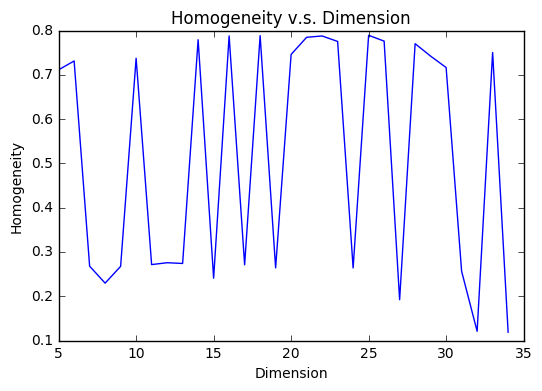

[[3869   34]
 [2949 1030]]
Homogeneity: 0.118776
Completeness: 0.208011
Adjusted Rand-Index: 0.058988
Adjusted Mutual Information: 0.118695


In [128]:
from sklearn.decomposition import NMF

dimension = range(5,35)
max_score = -1
scores = []
for n_components in dimension:
    nmf = NMF(n_components=n_components, max_iter=10, random_state=42)
    ppl = make_pipeline(nmf, Normalizer(copy=False))
    X_nmf = ppl.fit_transform(X_tfidf)

    km.fit(X_nmf)
    predict = km.labels_
    score = metrics.homogeneity_score(y, predict)
    scores.append(score)
    if score>max_score:
        max_score = score
        max_n_components = n_components
        nmf_model = km

print("%d dimensions give the max homogeneity score" % max_n_components)
plt.plot(dimension, scores)
plt.title("Homogeneity v.s. Dimension")
plt.xlabel("Dimension")
plt.ylabel("Homogeneity")
plt.show()

# clustering performance evaluations
predict = nmf_model.labels_
print(metrics.confusion_matrix(y, predict))
print("Homogeneity: %f" % metrics.homogeneity_score(y, predict))
print("Completeness: %f" % metrics.completeness_score(y, predict))
print("Adjusted Rand-Index: %f" % metrics.adjusted_rand_score(y, predict))
print("Adjusted Mutual Information: %f" % metrics.adjusted_mutual_info_score(y, predict))

- Applying Logarithm to Reduced Data from NMF

In [130]:
nmf = NMF(n_components=max_n_components, max_iter=10, random_state=42)
ppl = make_pipeline(nmf, Normalizer(copy=False))
X_nmf = ppl.fit_transform(X_tfidf)

min_max_scaler = MinMaxScaler()
X_nmf_minmax = min_max_scaler.fit_transform(X_nmf)
X_nmf_minmax[X_nmf_minmax<1e-10] = 1e-10
X_nmf_log = np.log(X_nmf_minmax)

km.fit(X_nmf_log)
predict = km.labels_

# clustering performance evaluations
print(metrics.confusion_matrix(y, predict))
print("Homogeneity: %f" % metrics.homogeneity_score(y, predict))
print("Completeness: %f" % metrics.completeness_score(y, predict))
print("Adjusted Rand-Index: %f" % metrics.adjusted_rand_score(y, predict))
print("Adjusted Mutual Information: %f" % metrics.adjusted_mutual_info_score(y, predict))

[[2202 1701]
 [1941 2038]]
Homogeneity: 0.004223
Completeness: 0.004230
Adjusted Rand-Index: 0.005630
Adjusted Mutual Information: 0.004131


- Applying RBF Kernel to Reduced Data from NMF

1950 dimensions give the max homogeneity score


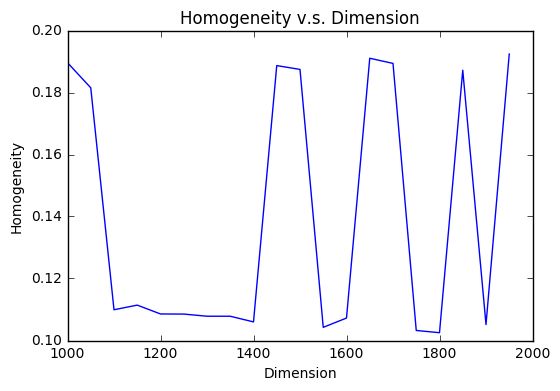

[[3882   21]
 [2531 1448]]
Homogeneity: 0.192419
Completeness: 0.277313
Adjusted Rand-Index: 0.124121
Adjusted Mutual Information: 0.192345


In [131]:
from sklearn.kernel_approximation import RBFSampler

dimension = range(1000,2000,50)
max_score = -1
scores = []
for n_components in dimension:
    rbfs = RBFSampler(n_components=n_components, random_state=42)
    ppl = make_pipeline(rbfs, Normalizer(copy=False))
    X_rbfs = ppl.fit_transform(X_nmf)
    km.fit(X_rbfs)
    predict = km.labels_
    score = metrics.homogeneity_score(y, predict)
    scores.append(score)
    if score>max_score:
        max_score = score
        max_n_components = n_components
        rbfs_model = km

print("%d dimensions give the max homogeneity score" % max_n_components)
plt.plot(dimension, scores)
plt.title("Homogeneity v.s. Dimension")
plt.xlabel("Dimension")
plt.ylabel("Homogeneity")
plt.show()

# clustering performance evaluations
predict = rbfs_model.labels_
print(metrics.confusion_matrix(y, predict))
print("Homogeneity: %f" % metrics.homogeneity_score(y, predict))
print("Completeness: %f" % metrics.completeness_score(y, predict))
print("Adjusted Rand-Index: %f" % metrics.adjusted_rand_score(y, predict))
print("Adjusted Mutual Information: %f" % metrics.adjusted_mutual_info_score(y, predict))

In [81]:
rbfs = RBFSampler(n_components=max_n_components, random_state=42)
ppl = make_pipeline(rbfs, Normalizer(copy=False))
X_rbfs = ppl.fit_transform(X_nmf)
km.fit(X_rbfs)
predict = km.labels_

# clustering performance evaluations
print(metrics.confusion_matrix(y, predict))
print("Homogeneity: %f" % metrics.homogeneity_score(y, predict))
print("Completeness: %f" % metrics.completeness_score(y, predict))
print("Adjusted Rand-Index: %f" % metrics.adjusted_rand_score(y, predict))
print("Adjusted Mutual Information: %f" % metrics.adjusted_mutual_info_score(y, predict))

[[ 106 3797]
 [2918 1061]]
Homogeneity: 0.449173
Completeness: 0.467573
Adjusted Rand-Index: 0.495
Adjusted Mutual Information: 0.449
